# AI Lab Run Evaluation
Including hiddim, recon and phonepred. 

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import torch
import torchaudio
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import random
from IPython.display import Audio
from tqdm import tqdm
import seaborn as sns
import pandas as pd
from collections import Counter
from sklearn.manifold import TSNE   # one type of clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from itertools import combinations
from sklearn.decomposition import PCA
from scipy.linalg import block_diag
import pickle
from scipy import stats

In [2]:
from model_padding import generate_mask_from_lengths_mat, mask_it
from paths import *
from misc_my_utils import *
from model_loss import *
from model_model import CTCPredNetV1 as TheLearner
from model_dataset import WordDatasetPath as ThisDataset
from model_dataset import Normalizer, DeNormalizer, TokenMap
from model_dataset import MelSpecTransformDB as TheTransform
from model_dataset import DS_Tools
from reshandler import DictResHandler
from misc_progress_bar import draw_progress_bar
from test_bnd_detect_tools import *
from misc_tools import PathUtils as PU
from misc_tools import AudioCut, ARPABET

## Preps

### Dirs

In [3]:
rec_dir = train_cut_word_
train_guide_path = os.path.join(src_, "guide_train.csv")
valid_guide_path = os.path.join(src_, "guide_validation.csv")
test_guide_path = os.path.join(src_, "guide_test.csv")

### Constants

In [4]:
EPOCHS = 10
BATCH_SIZE = 1

IN_DIM = 64
HID_DIM = 8

ENC_SIZE_LIST = {
    "in": IN_DIM, 
    "hid": HID_DIM
}
DEC_SIZE_LIST = {
    "hid": HID_DIM
}

DROPOUT = 0.5
NUM_LAYERS = 2
EMBEDDING_DIM = 128

REC_SAMPLE_RATE = 16000
N_FFT = 400
N_MELS = 64

LOADER_WORKER = 16

## Prepare for loading Model

In [5]:
ts = "0223155357"
stop_epoch = "99"
train_name = "B_06"
model_save_dir = os.path.join(model_save_, f"{train_name}-{ts}")
assert PU.path_exist(model_save_dir)
print(f"{train_name}-{ts}")

B_06-0223155357


## Load Dataset

In [6]:
TEST = False

In [7]:
with open(os.path.join(src_, "no-stress-seg.dict"), "rb") as file:
    # Load the object from the file
    mylist = pickle.load(file)
    mylist = ["BLANK"] + mylist

# Now you can use the loaded object
mymap = TokenMap(mylist)

mytrans = TheTransform(sample_rate=REC_SAMPLE_RATE, 
                       n_fft=N_FFT, n_mels=N_MELS, 
                       normalizer=Normalizer.norm_mvn, 
                       denormalizer=DeNormalizer.norm_mvn)

valid_ds = ThisDataset(rec_dir, 
                       valid_guide_path, 
                       transform=mytrans)

valid_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "valid.use"))

use_valid_ds = torch.utils.data.Subset(valid_ds, valid_ds_indices)

valid_loader = DataLoader(use_valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
valid_num = len(valid_loader.dataset)


# Load Test set
if TEST: 
    test_ds = ThisDataset(rec_dir, 
                        test_guide_path, 
                        transform=mytrans)
    test_ds_indices = DS_Tools.read_indices(os.path.join(model_save_dir, "test.use"))

    use_test_ds = torch.utils.data.Subset(test_ds, test_ds_indices)

    test_loader = DataLoader(use_test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
    test_num = len(test_loader.dataset)

## Model

### Model-related defs

In [8]:
DEC_SIZE_LIST["class"] = mymap.token_num()

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
recon_loss = nn.MSELoss(reduction='none')
masked_recon_loss = MaskedLoss(recon_loss)
model_loss = masked_recon_loss

# model = TheLearner(enc_size_list=ENC_SIZE_LIST, dec_size_list=DEC_SIZE_LIST, num_layers=2)
model = TheLearner(enc_size_list=ENC_SIZE_LIST, 
                   dec_size_list=DEC_SIZE_LIST, 
                   embedding_dim=EMBEDDING_DIM, 
                   num_layers=NUM_LAYERS, dropout=DROPOUT)
# model = TheLearner(enc_size_list=ENC_SIZE_LIST, dec_size_list=DEC_SIZE_LIST, num_layers=1)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

### Load Model

In [10]:
model_name = "{}.pt".format(stop_epoch)
model_path = os.path.join(model_save_dir, model_name)
state = torch.load(model_path)

model.load_state_dict(state)
model.to(device)

CTCPredNetV1(
  (encoder): CTCEncoderV1(
    (lin_1): Linear(in_features=64, out_features=8, bias=True)
    (rnn): LSTM(8, 8, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
    (lin_2): Linear(in_features=16, out_features=8, bias=True)
    (act): ReLU()
  )
  (decoder): CTCDecoderV1(
    (attention): ScaledDotProductAttention(
      (w_q): Linear(in_features=8, out_features=8, bias=True)
      (w_k): Linear(in_features=8, out_features=8, bias=True)
      (w_v): Linear(in_features=8, out_features=8, bias=True)
    )
    (lin_2): Linear(in_features=8, out_features=40, bias=True)
    (softmax): LogSoftmax(dim=-1)
  )
  (vq_embedding): Embedding(128, 8)
)

## Inference

In [11]:
def infer(): 
    model.eval()
    reshandler = DictResHandler(whole_res_dir=model_save_dir, 
                                 file_prefix="recon-encode")
    all_ze = []
    all_zq = []
    all_name = []
    all_attn = []

    for (x, x_lens, name) in tqdm(valid_loader): 
        name = name[0]

        x_mask = generate_mask_from_lengths_mat(x_lens, device=device)
        
        x = x.to(device)

        x_hat, attn_w, (ze, zq) = model(x, x_lens, x_mask)

        ze = ze.cpu().detach().numpy().squeeze()
        zq = zq.cpu().detach().numpy().squeeze()
        attn_w = attn_w.cpu().detach().numpy().squeeze()

        all_ze += [ze]
        all_zq += [zq]
        all_attn += [attn_w]
        # note that this is bit different, not each frame, but each sequence is treated as one data point
        all_name += [name]
    
    reshandler.res["ze"] = all_ze
    reshandler.res["zq"] = all_zq
    reshandler.res["name"] = all_name
    reshandler.res["attn"] = all_attn
    reshandler.save()

In [ ]:
if __name__ == "__main__": 
    infer()

100%|██████████| 51904/51904 [02:24<00:00, 359.35it/s]


# Load Res

In [12]:
reshandler = DictResHandler(whole_res_dir=model_save_dir, file_prefix="recon-encode")
reshandler.read()

# Plot some recon and original comparisons

In [13]:
# all
all_ze = reshandler.res["ze"]
all_zq = reshandler.res["zq"]
all_name = reshandler.res["name"]
all_attn = reshandler.res["attn"]

# read in guide file
guide_file = pd.read_csv(valid_guide_path)
# filtering out is not necessary, since we only include wuid for encoded words
guide_file = guide_file[~guide_file["segment_nostress"].isin(["sil", "sp", "spn"])]
filtered_df = guide_file[guide_file['wuid'].isin(all_name)].copy()

filtered_df["startFrame"] = filtered_df.apply(lambda x: time_to_frame(x['startTime'] - x['word_startTime']), axis=1)
filtered_df["endFrame"] = filtered_df.apply(lambda x: time_to_frame(x['endTime'] - x['word_startTime']), axis=1)

In [14]:
name_dict = {token: index for index, token in enumerate(all_name)}

## (1) Visualize Attention

In [15]:
def get_endframes(table, wuid): 
    selected_table = table[table["wuid"] == wuid]
    names = selected_table["segment_nostress"].tolist()
    startframes = selected_table["startFrame"].tolist()
    endframes = selected_table["endFrame"].tolist()
    return names, startframes, endframes

In [16]:
def plot_attention(attention_weights, names, startframes, endframes):
    # Ensure attention_weights is a square matrix
    assert attention_weights.shape[0] == attention_weights.shape[1], "Attention weights must be a square matrix."
    
    # Plot the heatmap
    # fig = plt.figure(figsize=(12, 10))
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6)
    ax.xaxis.set_ticks_position('top')  # This moves the ticks and labels to the top
    ax.xaxis.set_label_position('top')  # This moves the axis label to the top
    sns.heatmap(attention_weights, cmap='viridis', cbar=True)

    final_position = endframes[-1]
    
    # Plot lines for phoneme boundaries and annotate phoneme sounds
    for phoneme, start_frame, end_frame in zip(names, startframes, endframes):
        # Draw vertical and horizontal lines for start frames
        plt.axvline(x=start_frame, color='red', linestyle='--', linewidth=0.5)
        plt.axhline(y=start_frame, color='red', linestyle='--', linewidth=0.5)
        
        # Annotate phoneme sounds
        plt.text((start_frame + end_frame)/2, final_position + 1, phoneme, rotation=0, color='blue', fontsize=9, va="top")
        plt.text(final_position + 1, (start_frame + end_frame)/2, phoneme, rotation=0, color='blue', fontsize=9, ha='left')

    # plt.title('Attention Weights with Phoneme Boundaries and Sounds')
    plt.xlabel('Key')
    plt.ylabel('Query')
    plt.xlim(0, attention_weights.shape[1])  # Adjust the x-axis limit
    plt.ylim(attention_weights.shape[0], 0)  # Adjust the y-axis limit (inverted)
    plt.show()

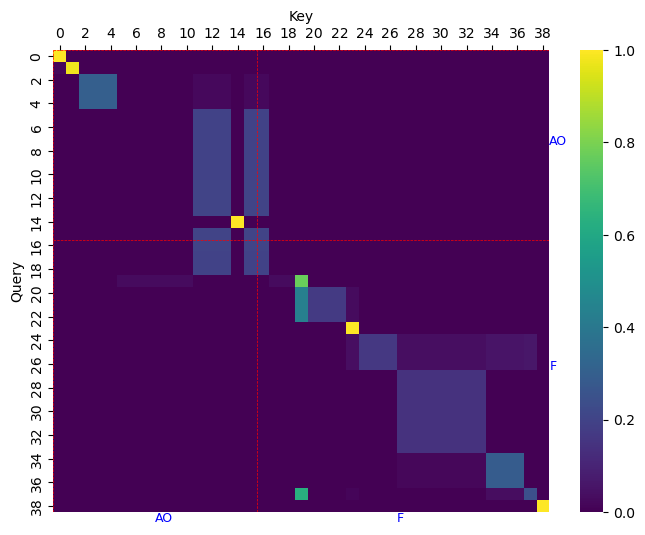

In [17]:
i = torch.randint(0, len(all_attn), size=(1, )).item()

this_attn = all_attn[i]
this_names, this_startframes, this_endframes = get_endframes(filtered_df, all_name[i])

plot_attention(this_attn, this_names, this_startframes, this_endframes)

### Stats

In [18]:
def create_phoneme_block_matrix(starts, ends, total):
    # Initialize an empty list to store phoneme block matrices
    phoneme_blocks = []

    # Iterate through the phoneme frames to create each block
    for start_frame, end_frame in list(zip(starts, ends))[:-1]:
        num_frames = end_frame - start_frame
        phoneme_block = np.ones((num_frames, num_frames))
        phoneme_blocks.append(phoneme_block)

    num_frames = total - starts[-1]
    phoneme_block = np.ones((num_frames, num_frames))
    phoneme_blocks.append(phoneme_block)
    block_diag_matrix = block_diag(*phoneme_blocks)

    return block_diag_matrix

In [19]:
def get_in_phone_attn(starts, ends, total): 
    block_diag_matrix = create_phoneme_block_matrix(starts, ends, total)
    filtered_attn = block_diag_matrix * this_attn
    in_phoneme_attn = filtered_attn.sum(-1)
    return in_phoneme_attn

In [20]:
def draw_in_phone_attn(names, starts, ends, total): 
    block_diag_matrix = create_phoneme_block_matrix(starts, ends, total)
    filtered_attn = block_diag_matrix * this_attn
    in_phoneme_attn = filtered_attn.sum(-1)

    # Generating an array of indices to represent each bar
    indices = np.arange(len(in_phoneme_attn))

    # Creating the bar graph
    plt.bar(indices, in_phoneme_attn)

    # Plot lines for phoneme boundaries and annotate phoneme sounds
    for phoneme, start_frame, end_frame in zip(names, starts, ends):
        # Draw vertical and horizontal lines for start frames
        plt.axvline(x=start_frame, color='red', linestyle='--', linewidth=0.5)
        
        # Annotate phoneme sounds
        plt.text((start_frame + end_frame)/2, 0, phoneme, rotation=0, color='blue', fontsize=9, va="top")

    # Adding title and axis labels
    plt.title('In-phoneme Attention And Boundary')
    plt.ylabel('Attention Weight (Sum)')
    plt.show()

# draw_in_phone_attn(this_names, this_startframes, this_endframes, this_attn.shape[0])

In [28]:
all_boundary_attn = []
all_middle_attn = []

for i in tqdm(range(len(all_name[:20]))): 
    this_attn = all_attn[i]
    attn_size = this_attn.shape[0]
    this_names, this_startframes, this_endframes = get_endframes(filtered_df, all_name[i])

    boundary_positions = this_endframes[:-1]
    middle_positions = ((np.array(this_startframes) + np.array(this_endframes)) / 2).astype(int).tolist()[:-1]

    if len(boundary_positions) < 1: 
        continue

    inphone_attn = get_in_phone_attn(this_startframes, this_endframes, attn_size)

    for pos in boundary_positions: 
        all_boundary_attn += inphone_attn[boundary_positions].tolist()
    for pos in middle_positions: 
        all_middle_attn += inphone_attn[middle_positions].tolist()

100%|██████████| 20/20 [00:00<00:00, 80.14it/s]


In [29]:
stats.ttest_ind(all_boundary_attn, all_middle_attn)

TtestResult(statistic=-2.624853236595663, pvalue=0.009366568219532466, df=192.0)

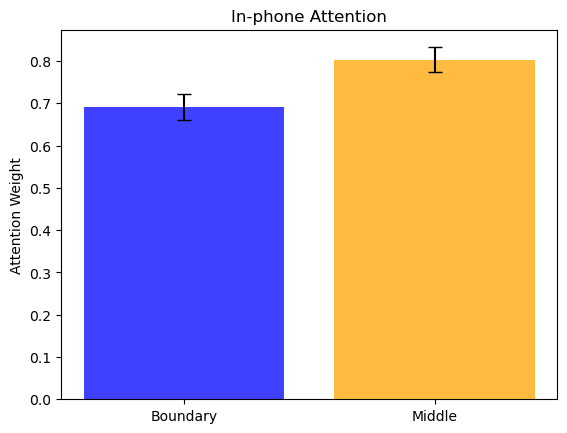

In [30]:
# Sample data
group1 = all_boundary_attn
group2 = all_middle_attn

# Calculate means
mean1 = np.mean(group1)
mean2 = np.mean(group2)

# Calculate standard error of the mean (SEM)
sem1 = np.std(group1, ddof=1) / np.sqrt(len(group1))
sem2 = np.std(group2, ddof=1) / np.sqrt(len(group2))

# Prepare plot
labels = ['Boundary', 'Middle']
means = [mean1, mean2]
errors = [sem1, sem2]

# Create the bar plot
plt.bar(labels, means, yerr=errors, capsize=5, color=['blue', 'orange'], alpha=0.75)

# Add title and labels
plt.title('In-phone Attention')
plt.ylabel('Attention Weight')

# Show the plot
plt.show()


- These statistics and plots tell us that in general, attention is more towards other phonemes at phoneme boundaries, which, although is well expected, reassures the good-functioning of our model's attention mechanism. 

- As for tomorrow, I will write codes to select recordings focusing on specific phonological phenomena. The example is aspiration of voiceless stops. We will check: 1. whether model trained on general data with autoencoder training can have attention that looks at the target (sibilant before stop, e.g. ) when decoding the sequences; 2. whether phoneme-prediction trained model can do this; 3. whether the model can do this when specifically trained to reconstruct only recordings with the selected phenomena. 

## (2) Visualize Hidden Representation

In [ ]:
def cutHid(hid, cutstart, cutend, start_offset=0, end_offset=1): 
    selstart = max(cutstart, int(cutstart + (cutend - cutstart) * start_offset))
    selend = min(cutend, int(cutstart + (cutend - cutstart) * end_offset))
    # hid is (L, H)
    return hid[selstart:selend, :]

In [ ]:
def get_toplot(data, name_dict, df, selector, max_counts=500, offsets=(0, 1)): 
    selected_df = pd.DataFrame(columns=df.columns)
    for item in selector:
        # Filter the DataFrame for the current item
        filtered_df = df[df['segment_nostress'] == item]
        
        # Check if the number of rows exceeds the maximum count
        if len(filtered_df) > max_counts:
            # Randomly sample max_counts[item] rows
            sampled_df = filtered_df.sample(n=max_counts, replace=False)
        else:
            sampled_df = filtered_df
        # Append to the selected_df
        selected_df = pd.concat([selected_df, sampled_df], axis=0)
    # selected_df = df[df["segment_nostress"].isin(cluster_groups)]
    selected_wuid = selected_df["wuid"].tolist()
    indices = [name_dict[token] for token in selected_wuid]
    selected_items = []
    for idx in indices: 
        selected_items.append(data[idx])
    cutstarts = selected_df["startFrame"]
    cutends = selected_df["endFrame"]

    hid_sel = np.empty((0, 8))
    tag_sel = []
    for (item, start, end, tag) in zip(selected_items, cutstarts, cutends, selected_df["segment_nostress"]): 
        hid = cutHid(item, start, end, offsets[0], offsets[1])
        hidlen = hid.shape[0]
        hid_sel = np.concatenate((hid_sel, hid), axis=0)
        tag_sel += [tag] * hidlen
    return hid_sel, np.array(tag_sel)

In [ ]:
import pickle
from model_dataset import TokenMap

with open(os.path.join(src_, "no-stress-seg.dict"), "rb") as file:
    # Load the object from the file
    mylist = pickle.load(file)
    mylist = ["BLANK"] + mylist

mymap = TokenMap(mylist)

### Multiplot by Phoneme

(0.0, 0.1)
(0.1, 0.2)
(0.2, 0.30000000000000004)
(0.30000000000000004, 0.4)
(0.4, 0.5)
(0.5, 0.6)
(0.6000000000000001, 0.7000000000000001)
(0.7000000000000001, 0.8)
(0.8, 0.9)
(0.9, 1.0)


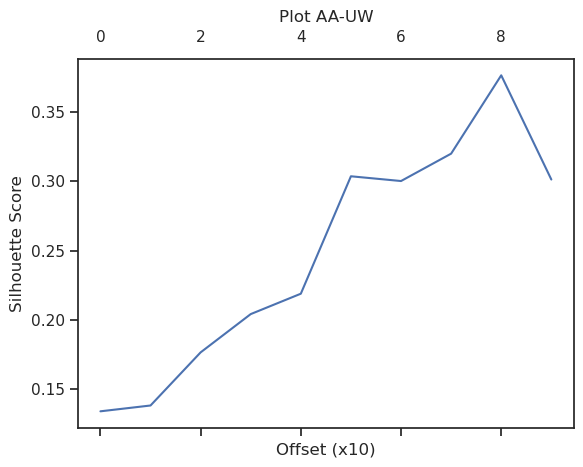

In [ ]:
cluster_groups = ["AA", "UW"]
sil_list = []
jumper = 0.1
x_range = range(int(1/jumper))

for offset_start_ten in x_range: 
    offsets = (offset_start_ten * jumper, offset_start_ten * jumper + jumper)
    print(offsets)
    # get usable cluster groups
    hidr_cs, tags_cs = get_toplot(data=all_zq, 
                                name_dict=name_dict, 
                                df=filtered_df, 
                                selector=cluster_groups, 
                                max_counts=1000, 
                                offsets=offsets)
    color_translate = {item: idx for idx, item in enumerate(cluster_groups)}
    # Use Counter to count the occurrences of each item
    item_counts = Counter(tags_cs)
    X, Y = hidr_cs, tags_cs
    silhouette_avg = silhouette_score(X, tags_cs)
    sil_list.append(silhouette_avg)

    # pca = PCA(n_components=2)  # Reduce to 2 dimensions
    # pca_result = pca.fit_transform(X)  # Make sure to convert from PyTorch tensor to NumPy array if necessary
    # plt.figure(figsize=(10, 7))  # Larger figure size for better visibility
    # scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=np.vectorize(mymap.encode)(Y), cmap='viridis', alpha=0.5)
    # plt.colorbar(scatter)
    # plt.xlabel('Principal Component 1')
    # plt.ylabel('Principal Component 2')
    # plt.title('PCA of Hidden Representations Colored by Ground Truth Labels')
    # plt.show()

plt.plot(x_range, sil_list) # Plot the points
plt.title(f'Plot {"-".join(cluster_groups)}')
plt.xlabel('Offset (x10)')
plt.ylabel('Silhouette Score')
plt.show()


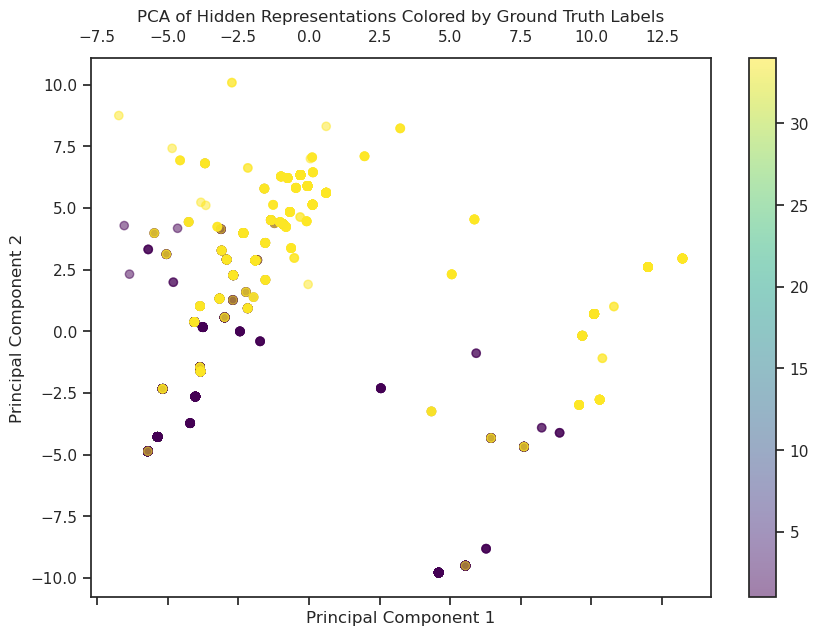

In [ ]:
pca = PCA(n_components=2)  # Reduce to 2 dimensions
pca_result = pca.fit_transform(X)  # Make sure to convert from PyTorch tensor to NumPy array if necessary

# Create a scatter plot colored by the ground truth labels
plt.figure(figsize=(10, 7))  # Larger figure size for better visibility
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=np.vectorize(mymap.encode)(Y), cmap='viridis', alpha=0.5)

# Add a color bar to show the correspondence between color and class
plt.colorbar(scatter)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Hidden Representations Colored by Ground Truth Labels')
plt.show()

In [ ]:
# Number of clusters
n_clusters = len(cluster_groups)

# Running KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(X)


In [ ]:
silhouette_avg = silhouette_score(X, tags_cs)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.30139467945511017


In [ ]:
adjusted_rand_score(tags_cs, cluster_labels)

0.005331292293559368

In [ ]:
v_measure_score(tags_cs, cluster_labels)

0.005535166157667687

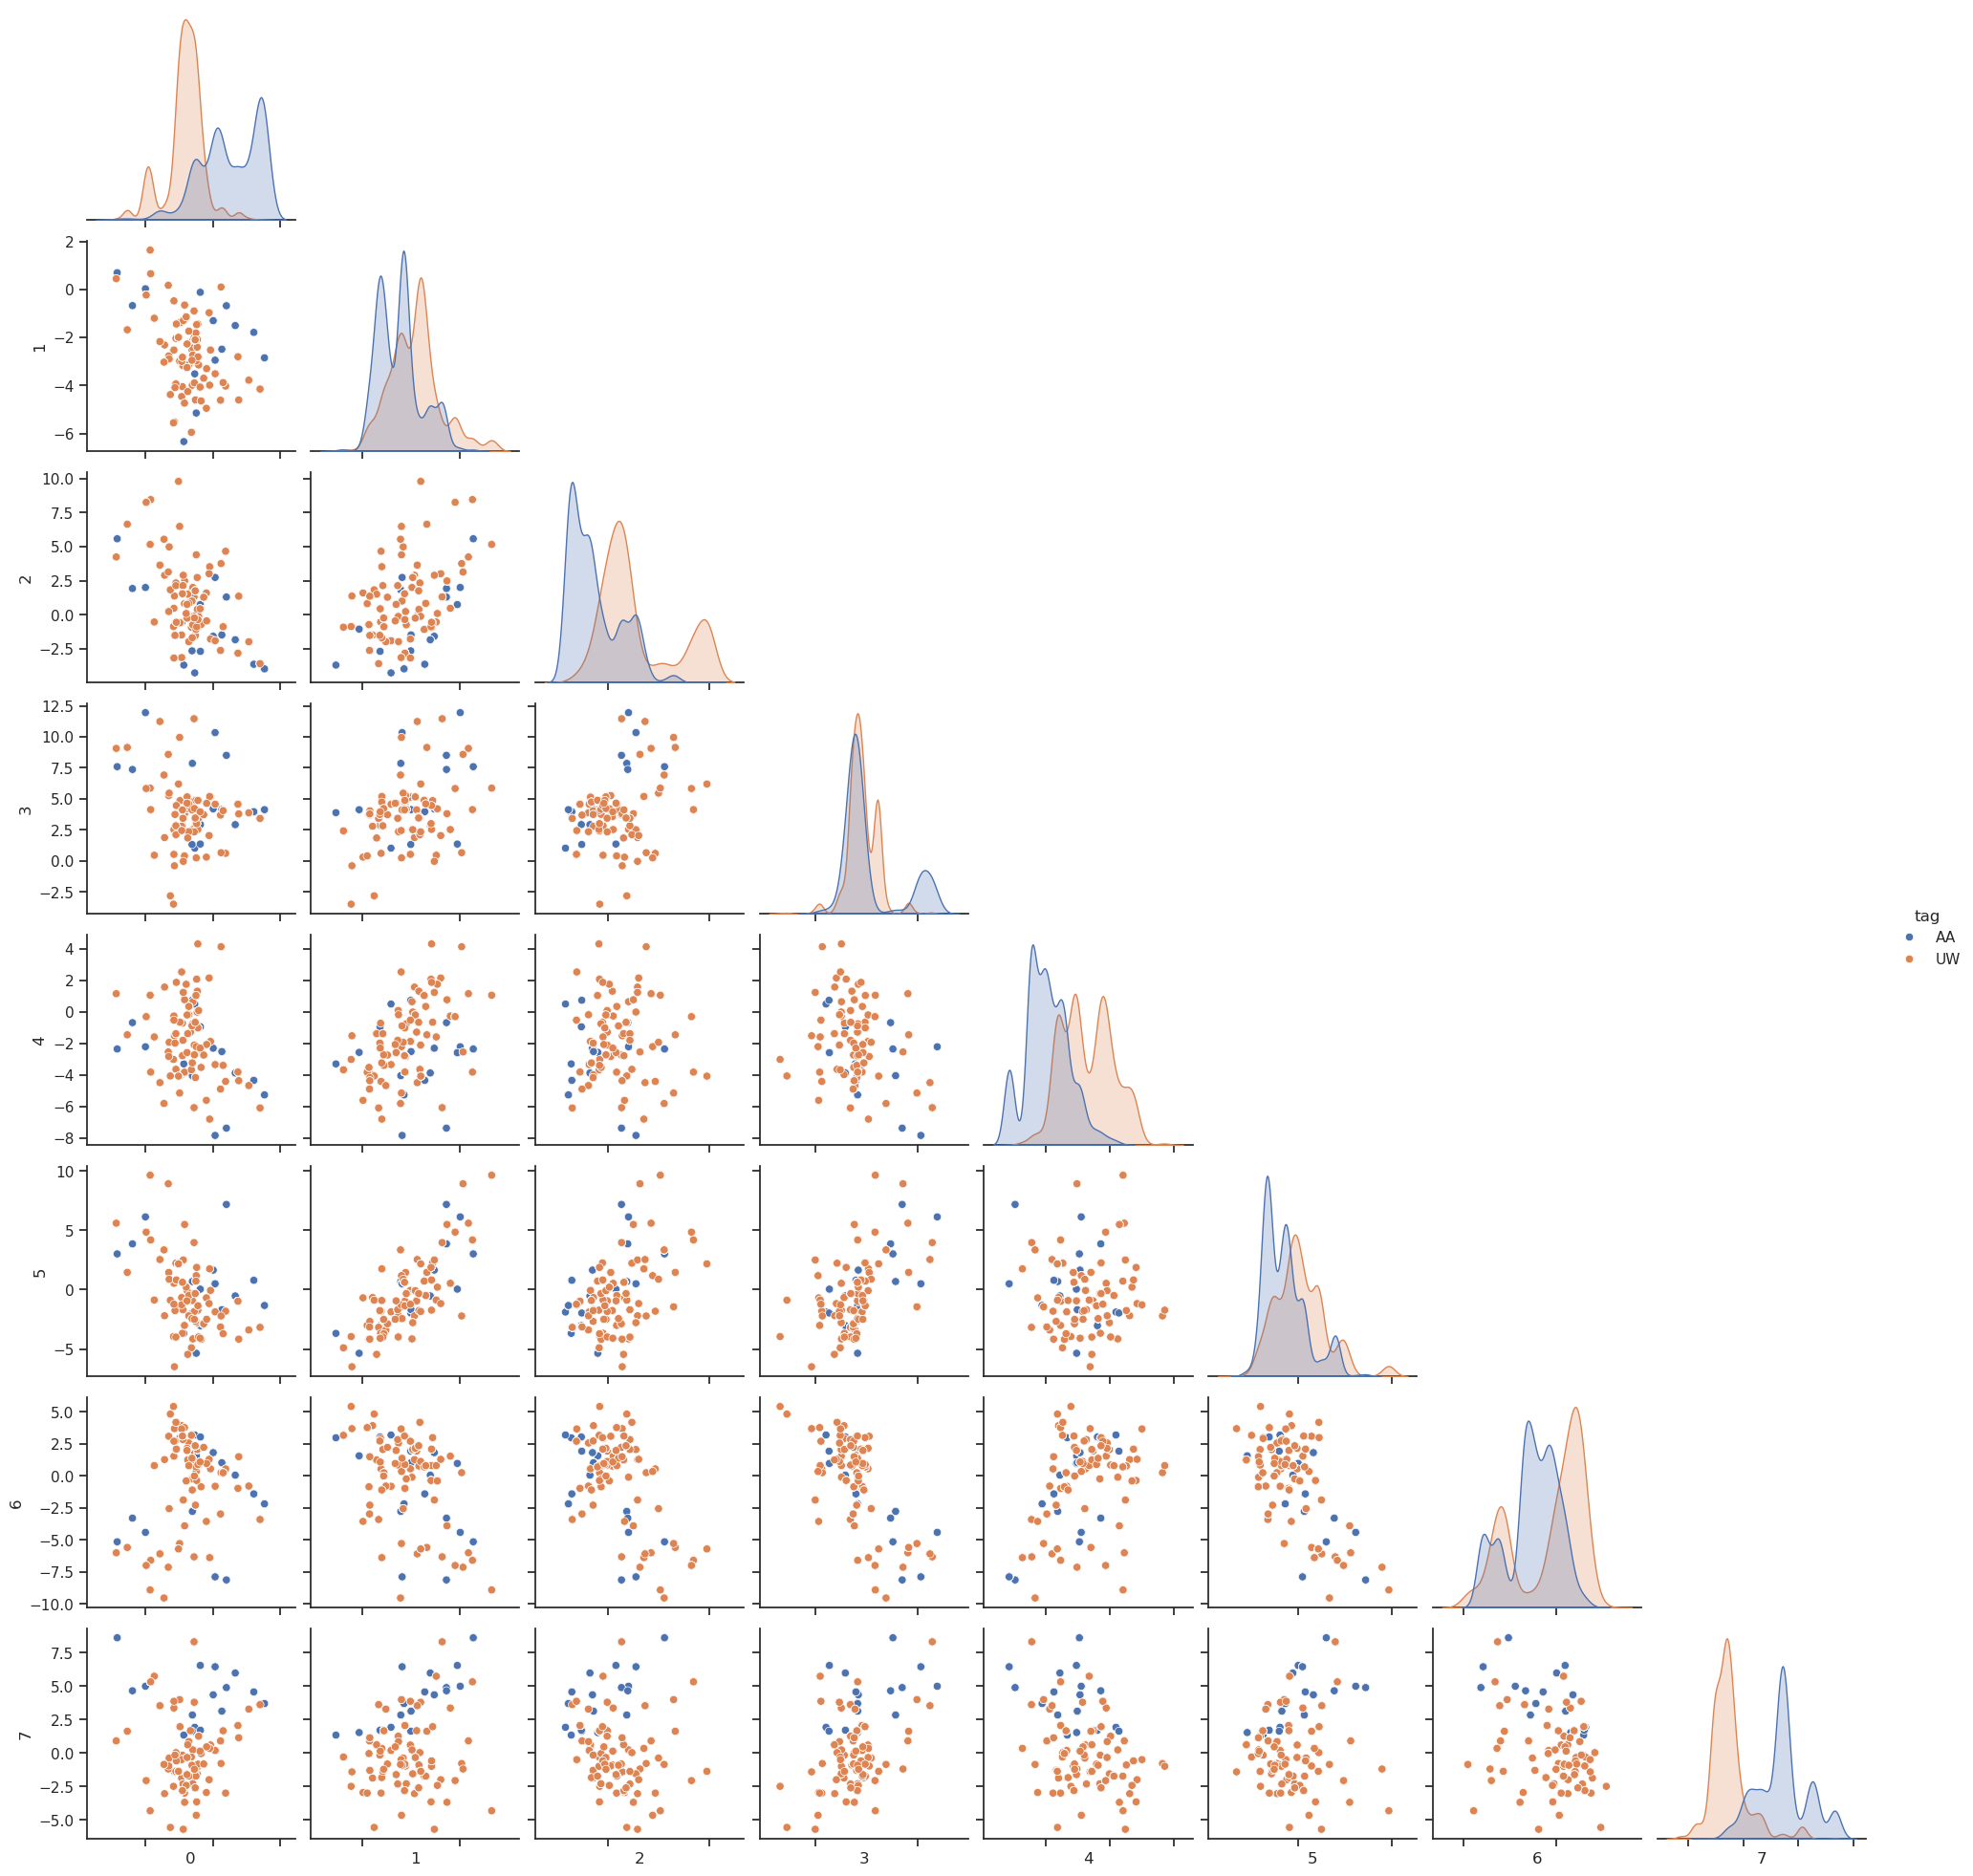

In [ ]:
X = hidr_cs
y = tags_cs

colors = [color_translate[item] for item in y]
df = pd.DataFrame(X)
df["tag"] = y

sns.set(style="ticks", color_codes=True)
g = sns.pairplot(df,hue='tag', corner=True, diag_kind="kde")
# g.map_lower(sns.kdeplot, levels=4, color=".2")

## Corr

In [ ]:
def dataframe_to_phonological_dict(df):
    phonological_dict = {}
    for index, row in df.iterrows():
        symbol = row['ARPABET']
        phonological_vector = np.array(row.iloc[3:], dtype=int)
        phonological_dict[symbol] = phonological_vector
    return phonological_dict

In [ ]:
def edit_dist(a, b): 
    # a, b being numpy arrays
    return np.sum(a != b)

In [ ]:
mapper = pd.read_csv("./english_to_feats.csv")
mapper = mapper[mapper["ARPABET"].notna()]

In [ ]:
mapperdict = dataframe_to_phonological_dict(mapper)

In [ ]:
all_v = filtered_df[filtered_df["segment_nostress"].isin(ARPABET.list_vowels())]["segment_nostress"].unique().tolist()
all_c = filtered_df[filtered_df["segment_nostress"].isin(ARPABET.list_consonants())]["segment_nostress"].unique().tolist()

In [ ]:
len(list(combinations(all_c, 2)))

276

In [ ]:
ssc = [] # silhouette score
eds = []

for (a, b) in list(combinations(all_v, 2)): 
    X, Y = get_toplot(data=all_zq, 
                              name_dict=name_dict, 
                              df=filtered_df, 
                              selector=[a, b], 
                              max_counts=1000, 
                              offsets=(0.6, 0.9))
    
    ssc.append(silhouette_score(X, Y))
    eds.append(edit_dist(mapperdict[a], mapperdict[b]))

In [ ]:
correlation_matrix = np.corrcoef(ssc, eds)
correlation = correlation_matrix[0, 1]
print(f"Pearson's correlation coefficient: {correlation}")


Pearson's correlation coefficient: 0.2937124497759047


In [ ]:
alltoken_out = pd.DataFrame({"edit_dist": eds, "silhouette": ssc})

<Axes: xlabel='edit_dist', ylabel='silhouette'>

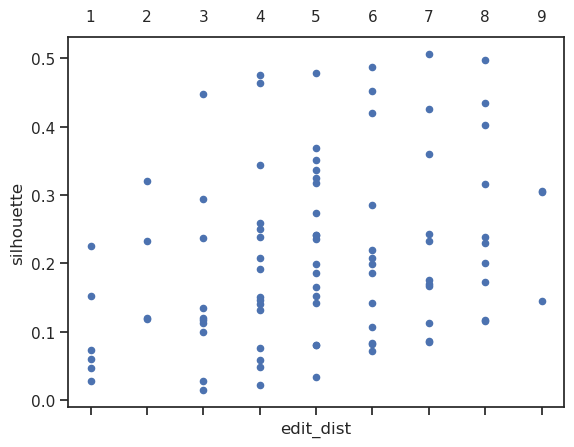

In [ ]:
alltoken_out.plot(x='edit_dist', y='silhouette', kind='scatter')

In [ ]:
alltoken_out[["edit_dist", "silhouette"]].corr()

,edit_dist,silhouette
edit_dist,1.000000,0.293712
silhouette,0.293712,1.000000


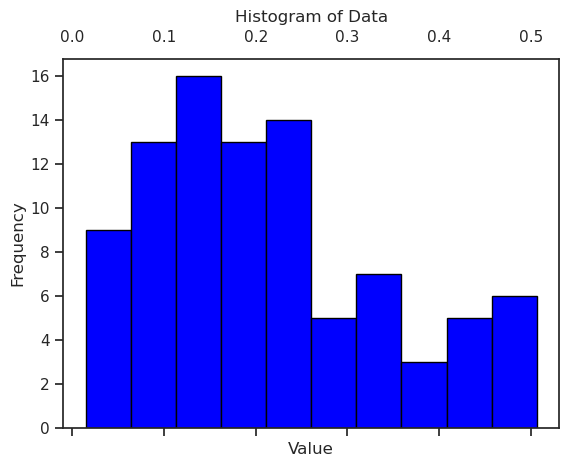

In [ ]:
# Creating the histogram
plt.hist(ssc, bins=10, color='blue', edgecolor='black')  # You can adjust the number of bins

# Adding titles and labels
plt.title('Histogram of Data')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Display the histogram
plt.show()

In [ ]:
np.array(ssc).mean()

0.21322373719680662